# Advanced Data Science with IBM
## Use Case: Fault prediction for bearings (anomaly detection)

The goal of this use case is to predict as soon as possible if and when the bearings should be changed or maintained. The following picture illustrates this use case with the 4 bearings:

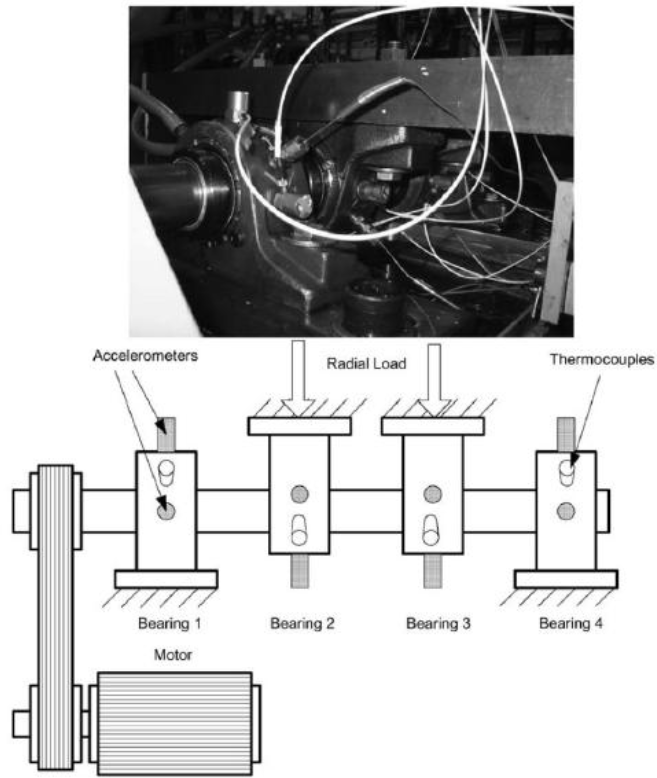

From http://data-acoustics.com/measurements/bearing-faults/bearing-4/ I downloaded this dataset with three sets of vibration measurement signals (IoT data) from bearings. These signals are provided for the datasets over the lifetime of the bearings until failure. The data was provided as tab separated text files which I converted to csv for an easier upload to python dataframes.
The dataset was not split into train and test data. In a real ML project the domain expert (e.g. an engineer) would tell me how to split this data so that he gets his expected results. The data was provided from February 12th 2004 to February 19th 2004. After analyzing the data in more detail I was pretty sure that the bearings worked fine the first 2 days so I used this time frame for the training data for the models

Beside the **ETL** part I have done all the coding in the IBM Watson Studio on the cloud in Jupyter Notebooks. The ETL part which also includes the EDA I have implemented on my local system (notebook "**bearing.etl.pyhton.01.ipynb**") so that I didn't need to upload so much data to the cloud. My IBM cloud access is free and so restricted regarding CPU,  RAM and processing time

### 1. Modeling - Preparation
In this chapter the models will be created.  
In a first step I will import the 2 csv files which I have prepared in the ETL notebook "bearing.etl.pyhton.01.ipynb":
1. **df_ok.csv**: IoT measure points of bearings without anomalies and without bearing failures. This measure points will be used to train the networks
2. **df_nok.csv**: IoT measure points of bearing with failure. With this data set we will see how our algorithms for detecting anomalies perform


In [1]:
#All import statements
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os, csv, glob, datetime, time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense
from matplotlib.dates import DateFormatter

#install pyod for knn outlier detection
!pip install pyod
from pyod.models.knn import KNN   # kNN detector

#to get rid of the warning execute register_matplotlib_converters() 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from botocore.client import Config
import ibm_boto3
%matplotlib inline

Using TensorFlow backend.


     |████████████████████████████████| 92kB 16.3MB/s eta 0:00:01
     |████████████████████████████████| 286kB 23.7MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/30/2f/4a/90c7bf3403325384b1c2ef5eb50d65d7467b8dd1b64a92ab82
Successfully built pyod


In [2]:
# import the training data without bearing failure
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_b2d04bb960e541b59bf748286f30fef3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HXB6bIyaokBGw-eWQ7IlD3GvZyZhVYDCePt5uiSYMZnq',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_nok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_nok = pd.read_csv(body)
df_nok.index = pd.DatetimeIndex(df_nok.date)
df_nok = df_nok.drop(['date'], axis=1)

In [3]:
#Import test data which contains the bearing failures
body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_ok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ok = pd.read_csv(body)
df_ok.index = pd.DatetimeIndex(df_ok.date)
df_ok = df_ok.drop(['date'], axis=1)

In [4]:
#get overview about the data
df_ok.head()

,bearing1,bearing2,bearing3,bearing4
date,,,,
2004-02-12 10:40:00,0.127896,0.457060,0.556003,0.365093
2004-02-12 10:50:00,0.130644,0.458403,0.552573,0.364258
2004-02-12 11:00:00,0.133330,0.456029,0.556160,0.369705
2004-02-12 11:10:00,0.133125,0.467033,0.545364,0.370022
2004-02-12 11:20:00,0.133806,0.452518,0.558971,0.361946


In [5]:
#get overview about the data
df_ok.describe()

,bearing1,bearing2,bearing3,bearing4
count,224.000000,224.000000,224.000000,224.000000
mean,0.132014,0.466941,0.525509,0.361078
std,0.001858,0.004504,0.011830,0.004477
min,0.127639,0.452518,0.499072,0.350592
25%,0.130690,0.464006,0.517033,0.358072
50%,0.131935,0.467231,0.524785,0.361095
75%,0.133341,0.469910,0.533294,0.364009
max,0.137210,0.480742,0.558971,0.374626


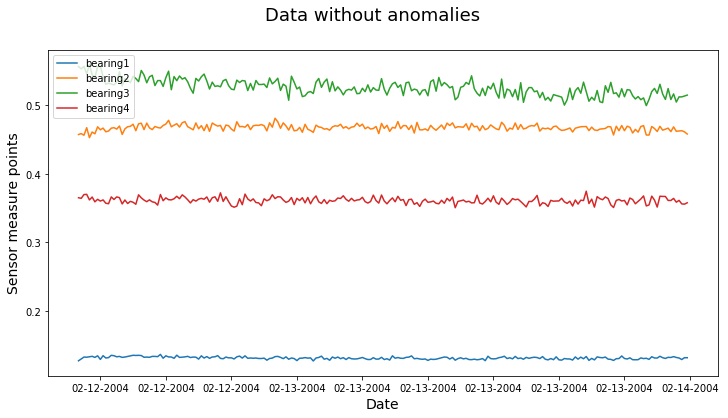

In [6]:
#plot the data without anomalies

# Define the date format
myFmt = DateFormatter('%m-%d-20%y') 

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_ok.bearing1)
ax.plot(df_ok.bearing2)
ax.plot(df_ok.bearing3)
ax.plot(df_ok.bearing4)
ax.xaxis.set_major_formatter(myFmt)
fig.suptitle('Data without anomalies', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sensor measure points', fontsize=14)
ax.legend(loc="upper left")

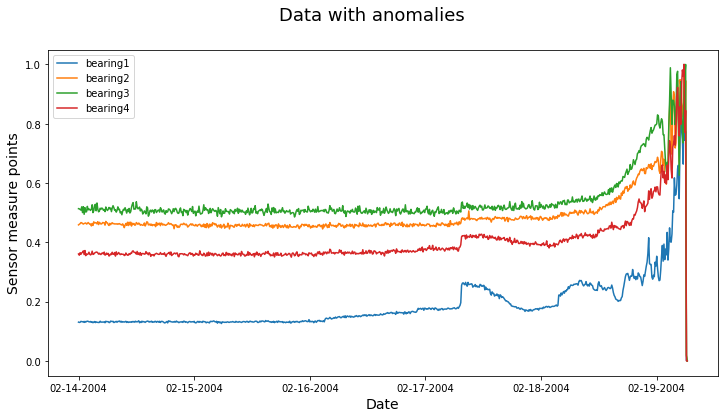

In [7]:
#plot the data with anomalies

# Define the date format
myFmt = DateFormatter('%m-%d-20%y') 

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_nok.bearing1)
ax.plot(df_nok.bearing2)
ax.plot(df_nok.bearing3)
ax.plot(df_nok.bearing4)
ax.xaxis.set_major_formatter(myFmt)
fig.suptitle('Data with anomalies', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sensor measure points', fontsize=14)
ax.legend(loc="upper left")

In above picture we can clearly see the bearings failure

### 2. Modeling
I prepared 3 models to detect the bearings failure as soon as possible:
1. Autoencoder Neural Network with LSTM
2. Autencoder Neural Network
3. KNN Classification (only implemented in the evaluation chapter)

Why I have chosen an LSTM Network:
* In oppostion to e.g. Recurrent Networks, LSTM Networks have the advantage to remember things over long durations of time. To be able to to this, LSTM maintains a cell state as well as a carry for ensuring that the signal is not lost as the sequence is processed
* LSTM networks are used to overcome the issue with Vanishing Gradience

#### Model 1 - Autoencoder Neural Network with LSTM

In [8]:
#reshape the dataframe according to the LSTM input shape
def reshape_lstm(df,timesteps,dim=4):
    #df: dataframe
    #timesteps: int with number of timesteps
    #dim: int with number ot timesteps
    
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps   #trim is necessary to be able to reshpape
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [9]:
#Modeling - design LSTM network
#Using LSTM layers is a way to introduce memory to neural networks that 
#makes them ideal for analyzing time-series and sequence data.
def create_lstm(timesteps=10, dim=4):
    model = Sequential()
    model.add(LSTM(32,input_shape=(timesteps,dim),return_sequences=True))  
    model.add(LSTM(16,return_sequences=True)) 
    model.add(Dense(4))
    
    model.compile(loss='mae', optimizer='adam')
    #mae: the error during training and validation is measured using the “mean absolute error” measure.
    #adam: Method for Stochastic Optimization. It has little memory requirements, is invariant to 
    #diagonal rescaling of the gradients, and is good for problems that are large in terms of data and/or parameters.
    
    return model

In [10]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [11]:
# test if shape is OK for LSTM
lstm_ok.shape

(22, 10, 4)

In [12]:
# create LSTM model
lstm_model = create_lstm()

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#details about the number of parameters and output shapes of each layer and an overall model structure
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            3136      
_________________________________________________________________
dense_1 (Dense)              (None, 10, 4)             68        
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


#### Model 2 -  Deep Learning Autoencoder with Dense Layer

In [14]:
# Modeling - design neural network
def create_model_NN(df):
    act_func = 'elu'
    model = Sequential()
    model.add(Dense(10,activation=act_func,
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_shape=(df.shape[1],)))
    model.add(Dense(2,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(10,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(df.shape[1], kernel_initializer='glorot_uniform'))

    model.compile(loss='mae', optimizer='adam')
    #mae: the error during training and validation is measured using the “mean absolute error” measure.
    #adam: Method for Stochastic Optimization. It has little memory requirements, is invariant to 
    #diagonal rescaling of the gradients, and is good for problems that are large in terms of data and/or parameters.
    
    return model

In [15]:
#create the model
dense_model = create_model_NN(df_ok)

In [16]:
# save model and architecture to single file
lstm_model.save("lstm_model.h5")
dense_model.save("dense_model.h5")
# knn model will not be saved because of issues with pyod

### 3 Train the models

#### 3.1 Train LSTM models

In [17]:
#train the lstm model
def train_lstm(data,test, model, iterations):
    # data: reshaped data array
    # model: lstm model
    #iteration: int with number of training iterations
    
    for i in range(iterations):
        # we train an autoencoder model so we have same input and output data
        model_lstm = model.fit(data, data, epochs=100, batch_size=72,
                               validation_split=0.05, verbose=1, shuffle=False)        
    return model_lstm

In [18]:
#reshape the dataframe according to the LSTM input shape
def reshape_lstm(df,timesteps,dim=4):
    #df: dataframe
    #timesteps: int with number of timesteps
    #dim: int with number ot timesteps
    
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [19]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [20]:
#details about the number of parameters and output shapes of each layer and an overall model structure
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            3136      
_________________________________________________________________
dense_1 (Dense)              (None, 10, 4)             68        
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [21]:
# train the model
lstm_hist = train_lstm(lstm_ok, lstm_nok,lstm_model,5)

Instructions for updating:
Use tf.cast instead.
Train on 20 samples, validate on 2 samples
Epoch 1/100
20/20 [==============================] - 4s 211ms/step - loss: 0.3801 - val_loss: 0.3675
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.3714 - val_loss: 0.3560
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.3598 - val_loss: 0.3446
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.3483 - val_loss: 0.3332
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.3369 - val_loss: 0.3224
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.3260 - val_loss: 0.3114
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.3149 - val_loss: 0.3000
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.3034 - val_loss: 0.2891
Epoch 9/100
20/20 [==============================] - 0s 9ms/step - loss: 0.2925 - val_loss: 0.2797
Epoch 10/100
20

Epoch 80/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0680 - val_loss: 0.0666
Epoch 81/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0674 - val_loss: 0.0659
Epoch 82/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0667 - val_loss: 0.0651
Epoch 83/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0659 - val_loss: 0.0643
Epoch 84/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0651 - val_loss: 0.0636
Epoch 85/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0645 - val_loss: 0.0631
Epoch 86/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0640 - val_loss: 0.0624
Epoch 87/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0615
Epoch 88/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0624 - val_loss: 0.0609
Epoch 89/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0617 - val_loss: 0

Epoch 62/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0301 - val_loss: 0.0308
Epoch 63/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0299 - val_loss: 0.0305
Epoch 64/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0296 - val_loss: 0.0303
Epoch 65/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0294 - val_loss: 0.0301
Epoch 66/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0299
Epoch 67/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0289 - val_loss: 0.0297
Epoch 68/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0286 - val_loss: 0.0295
Epoch 69/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0284 - val_loss: 0.0294
Epoch 70/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0282 - val_loss: 0.0292
Epoch 71/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0279 - val_loss: 0.02

Epoch 44/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 45/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0170
Epoch 46/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 47/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0168
Epoch 48/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0167
Epoch 49/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0156 - val_loss: 0.0165
Epoch 50/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 51/100
20/20 [==============================] - 1s 34ms/step - loss: 0.0154 - val_loss: 0.0162
Epoch 52/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 53/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0151 - val_loss: 0.015

Epoch 26/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 27/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 28/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 29/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 30/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 31/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 32/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 33/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 34/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0092 - val_loss: 0.0099
Epoch 35/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.009

Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 9/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 11/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 12/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 13/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 14/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 15/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 16/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 17/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0045


Epoch 90/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 91/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 92/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 93/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 94/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 95/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 96/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 97/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 98/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 99/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.004

#### 3.2. Train Dense model

In [22]:
# Modeling - train neural network
def train_NN(data, model,batch_size=10,epochs=50):
    # data: dataframe
    
    history=model.fit(np.array(data),np.array(data),
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.05,
                      verbose = 1)
    return history

In [23]:
#details about the number of parameters and output shapes of each layer and an overall model structure
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [24]:
dense_hist = train_NN(df_ok, dense_model)

Train on 212 samples, validate on 12 samples
Epoch 1/50
212/212 [==============================] - 1s 5ms/step - loss: 0.4133 - val_loss: 0.2915
Epoch 2/50
212/212 [==============================] - 0s 168us/step - loss: 0.2370 - val_loss: 0.1583
Epoch 3/50
212/212 [==============================] - 0s 168us/step - loss: 0.1063 - val_loss: 0.0429
Epoch 4/50
212/212 [==============================] - 0s 178us/step - loss: 0.0276 - val_loss: 0.0064
Epoch 5/50
212/212 [==============================] - 0s 167us/step - loss: 0.0068 - val_loss: 0.0063
Epoch 6/50
212/212 [==============================] - 0s 147us/step - loss: 0.0051 - val_loss: 0.0042
Epoch 7/50
212/212 [==============================] - 0s 181us/step - loss: 0.0051 - val_loss: 0.0056
Epoch 8/50
212/212 [==============================] - 0s 172us/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/50
212/212 [==============================] - 0s 186us/step - loss: 0.0050 - val_loss: 0.0055
Epoch 10/50
212/212 [==================

In [25]:
# Get the dictionary containing each metric and the loss for each epoch
history_lstm = lstm_hist.history
history_dense = dense_hist.history

# Save it under the form of a json file
json.dump(history_lstm, open('lstm_hist', 'w'))
json.dump(history_dense, open('dense_hist', 'w'))

### 4. Evaluate models

#### 4.1. Evaluate LSTM model

In [26]:
#plot the Loss distributed over the Epochs
def dist_epochs(hist_obj, ylim_max):
    # hist_obj: dictionary object
    # ylim_max: float with max for y-achse

#    ylim_max = max(hist_obj.history['loss'] + lstm_hist.history['val_loss'])
    plt.plot(hist_obj.history['loss'], 'b', label='Training loss')
    plt.plot(hist_obj.history['val_loss'], 'r', label='Validation loss')
    plt.ylim([0,ylim_max])
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss, [mae]',fontsize=14)
    plt.legend(loc='upper right')
    plt.title('Plot of Training and Validation Loss', fontsize=18)
    plt.show()

In [27]:
def reshape_lstm(df,timesteps,dim=4):
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [28]:
#plot distribution of scores to find the threshold for the anomaly
def score_dist(score_series, bins,xlim_max):
    # score_series: panda series
    # bins: integer
    # xlim: e.g. 0.5
    
#    xlim_max = max(score_series)  
    plt.figure()
    sns.distplot(score_series,
             bins = bins, 
             kde= True,
            color = 'blue');
    plt.title('Distribution of loss')
    plt.xlim([0.0, xlim_max])

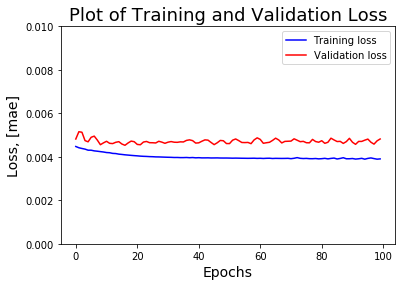

In [29]:
#plot the Loss, distributed over the Epochs
dist_epochs(lstm_hist,0.01)

In [30]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [31]:
lstm_ok.shape

(22, 10, 4)

In [32]:
#prediction for OK data
train_prediction = lstm_model.predict(np.array(lstm_ok))
train_pred_reshaped = train_prediction.reshape(lstm_ok.shape[0]*lstm_ok.shape[1],lstm_ok.shape[2])
train_pred_reshaped = pd.DataFrame(train_pred_reshaped, columns=df_ok.columns)
train_pred_reshaped.index = df_ok.index[:lstm_ok.shape[0]*lstm_ok.shape[1]]

#create Panda Series with scores
train_score = pd.DataFrame(index=df_ok.index)
train_score['Loss_mae'] = np.mean(np.abs(train_pred_reshaped-df_ok), axis = 1)

In [33]:
#print max score for estimation of the threshold
print('The maximum score for the training data is {:.2f}'.format(max(train_score['Loss_mae'])))

The maximum score for the training data is 0.01


/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


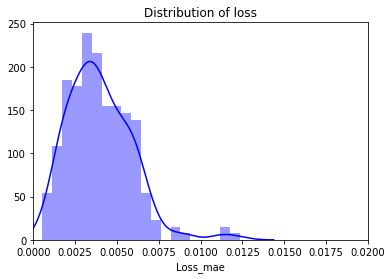

In [67]:
#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score['Loss_mae'], 20,0.02)

In [50]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
lstm_threshold = 0.0125

In [51]:
#create df with classification column and Threshold for train data
train_score['Threshold'] = lstm_threshold   # Domain expert has to define this threshold for the anomalies
train_score['Anomaly'] = train_score['Loss_mae'] > train_score['Threshold']

In [52]:
#prediction for Not OK data
test_prediction = lstm_model.predict(np.array(lstm_nok))
test_pred_reshaped = test_prediction.reshape(750,4)
test_pred_reshaped = pd.DataFrame(test_pred_reshaped, columns=df_nok.columns)
test_pred_reshaped.index = df_nok.index[:750]

#create Panda Series with scores
test_score = pd.DataFrame(index=df_nok.index)
test_score['Loss_mae'] = np.mean(np.abs(test_pred_reshaped-df_nok), axis = 1)

#create df with classification column and Threshold for test data
test_score['Threshold'] = lstm_threshold
test_score['Anomaly'] = test_score['Loss_mae'] > test_score['Threshold']

lstm_score = pd.concat([train_score, test_score])

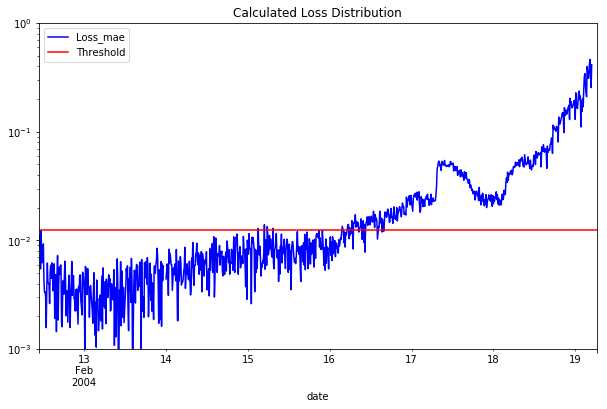

In [65]:
#plot the result
lstm_score.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e0], color = ['blue','red'], title='Calculated Loss Distribution')
plt.legend(loc='upper left')

#### 4.2 Evaluate Dense model

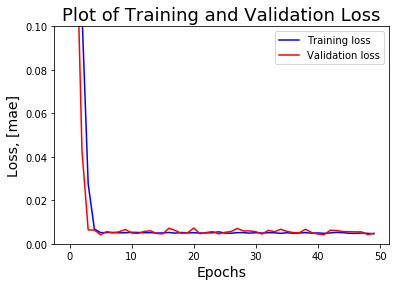

In [39]:
#plot the Loss, distributed over the Epochs
dist_epochs(dense_hist,0.1)

In [40]:
#prediction for OK data
train_pred_d = dense_model.predict(np.array(df_ok))
train_pred_d = pd.DataFrame(train_pred_d, columns=df_ok.columns)
train_pred_d.index = df_ok.index

#create Panda Series with scores
train_score_d = pd.DataFrame(index=df_ok.index)
train_score_d['Loss_mae'] = np.mean(np.abs(train_pred_d-df_ok), axis = 1)

#print max score for estimation of the threshold
print('The maximum score for the training data is {:.2f}'.format(max(train_score_d['Loss_mae'])))

The maximum score for the training data is 0.01


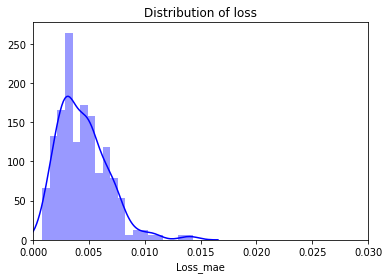

In [41]:
#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score_d['Loss_mae'], 20, 0.03)

In [60]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
dense_threshold = 0.015

In [61]:
#create df with classification column and Threshold for train data
train_score_d['Threshold'] = dense_threshold   # Domain expert has to define this threshold for the anomalies
train_score_d['Anomaly'] = train_score_d['Loss_mae'] > train_score_d['Threshold']

In [62]:
#prediction for Not OK data
test_pred_d = dense_model.predict(np.array(df_nok))
test_pred_d = pd.DataFrame(test_pred_d, columns=df_nok.columns)
test_pred_d.index = df_nok.index

#create df with classification column and Threshold
test_score_d = pd.DataFrame(index=df_nok.index)
test_score_d['Loss_mae'] = np.mean(np.abs(test_pred_d-df_nok), axis = 1)
test_score_d['Threshold'] = dense_threshold      
test_score_d['Anomaly'] = test_score_d['Loss_mae'] > test_score_d['Threshold']
score_d = pd.concat([train_score_d, test_score_d])

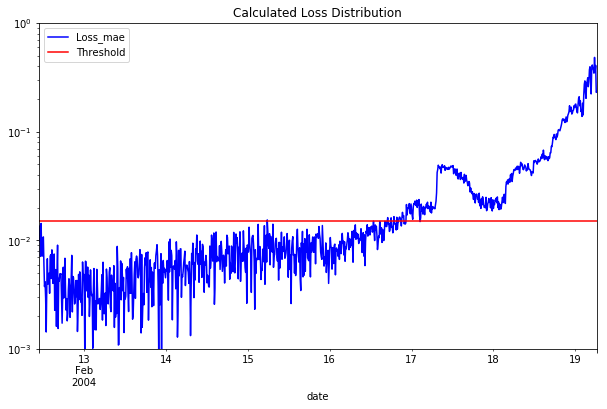

In [66]:
#plot the result
score_d.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e0], color = ['blue','red'],title='Calculated Loss Distribution')
plt.legend(loc='upper left')

### 5. Create, model, train and evaluate KNN model

I added this model just to have a comparison to the autencoder networks

In [46]:
# create and train kNN detector
clf_knn = KNN(n_neighbors=2, method='median')
clf_knn.fit(df_nok)

# get the prediction label and outlier scores of the training data
y_train_pred = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf_knn.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf_knn.predict(df_nok)  # outlier labels (0 or 1)
y_test_scores = clf_knn.decision_function(df_nok)  # outlier scores

In [47]:
clf_knn.threshold_

0.014949806661775162

In [48]:
#create df with classification column and Threshold
test_score_k = pd.DataFrame(index=df_nok.index)
test_score_k['Score'] = y_test_scores
test_score_k['Threshold'] = clf_knn.threshold_      
test_score_k['Anomaly'] = test_score_k['Score'] > test_score_k['Threshold']

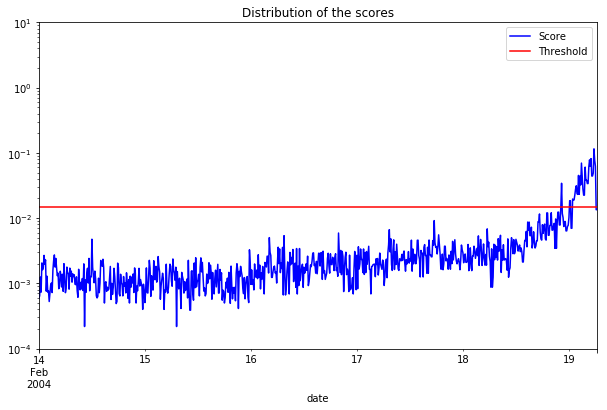

In [68]:
#plot the result
test_score_k.plot(logy=True,  figsize = (10,6), ylim = [1e-4,1e1], color = ['blue','red'],title='Distribution of the scores')

### 6. Interpretation

The NN with Dense Layer only and the LSTM network perform similary in this case. Both show the fault prediction with the date around Feb 16th 2004 which is really good. The KNN model can only predict the anomaly in a very late stage where the bearings are already nearly broken - so much too late.  
There are many improvements that could be done for those neural networks regarding the model parameters but for this use case example the results are very promising also for a production environment. It would be interesting to test these models with longer time series.  After some parameter changes I would guess that the LSTM model will deliver better results

### 7. Possible improvements
* Model parameter optimization
* Further code cleaning and optimization
* Use of Spark ML to improve scalability and performance
* Use of SAP HANA database to improve performance